In [16]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings

import logging

from skimage import measure 
from scipy.optimize import minimize
import plotly.graph_objects as go
from shapely.geometry import LineString
import matplotlib.patheffects as path_effects
from matplotlib.patches import Polygon as MplPolygon

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

In [17]:
alpha = "25" #compare to article this is 100(1-alpha) 
nbpd = 20 # maybe trying with 40 once the legends are added
nd = 4
same_rank_bool = True # if False then the jdist ranks are computed for ocean and land, rather than for both

fig_path = f"/scratchx/mcarenso/tempest/figures/all_ratios_nd_{nd}_nbpd_{nbpd}_alpha_{alpha}_same_rank_{str(same_rank_bool)}.png"

In [18]:
def apply_mask(data, mask, mask_compat):
    shape = np.shape(data)
    mask = mask_compat & mask  # join mask
    
    fdata, fmask = data.reshape(-1), mask.reshape(-1)
    fdata[~fmask] = np.nan
    rdata = fdata.reshape(shape)
    return rdata

# Objective function to minimize
def objective(coeff, data, data2):
    # Reshape to 1D and remove NaNs
    data_flat = data.reshape(-1)
    data2_flat = data2.reshape(-1)

    # Remove NaNs
    valid_indices = ~np.isnan(data_flat) & ~np.isnan(data2_flat)
    data_flat = data_flat[valid_indices]
    data2_flat = data2_flat[valid_indices]

    # Apply the coefficient to data2
    scaled_data2 = coeff * data2_flat
    
    # Calculate the Frobenius norm
    norm = np.linalg.norm(data_flat - scaled_data2)
    return norm

def compute_sigma_ratios(data_obs, data_list, jds): #sigma_density_obs_winter, sigma_density_winter_models
    data = np.copy(data_obs.T)
    n_models = len(data_list)
    coeffs = np.zeros((n_models, 4)) #90th km, 99th km, 90th dd, 99th dd
    norm_fits = np.zeros((n_models, 4))    #90th km, 99th km, 90th dd, 99th dd
    n_points = np.zeros((n_models, 4))
    
    for i, sigma_density_model in enumerate(data_list):
        jd = jds[i]
        jd.make_mask()
        data2 = np.copy(sigma_density_model.T) ## Here the first transpose !!! sneaky sneaky so don't fortget to transpose the mask as well 

        # Mask creation
        mask_compat = (~np.isnan(data)) & (~np.isnan(data2))
        mask_dd = jd.mask_coloc_ac_90.T
        mask_km = jd.mask_coloc_c_90.T

        # Initial coefficients
        coeff_dd = 1
        coeff_km = 1

        # Apply masks
        data_km_90th = apply_mask(data, mask_km, mask_compat)[20:40, 20:40]
        data2_km_90th = apply_mask(data2, mask_km, mask_compat)[20:40, 20:40]

        data_dd_90th = apply_mask(data, mask_dd, mask_compat)[20:40, 20:40]
        data2_dd_90th = apply_mask(data2, mask_dd, mask_compat)[20:40, 20:40]

        data_km_99th = apply_mask(data, mask_km, mask_compat)[40:, 40:]
        data2_km_99th = apply_mask(data2, mask_km, mask_compat)[40:, 40:]

        data_dd_99th = apply_mask(data, mask_dd, mask_compat)[40:, 40:]
        data2_dd_99th = apply_mask(data2, mask_dd, mask_compat)[40:, 40:]


        # Optimization for dd coefficient
        result_dd_90th = minimize(objective, coeff_dd, args=(data_dd_90th, data2_dd_90th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_dd_90th = result_dd_90th.x[0]
        result_dd_99th = minimize(objective, coeff_dd, args=(data_dd_99th, data2_dd_99th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_dd_99th = result_dd_99th.x[0]

        # Optimization for km coefficient
        result_km_90th = minimize(objective, coeff_km, args=(data_km_90th, data2_km_90th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_km_90th = result_km_90th.x[0]
        result_km_99th = minimize(objective, coeff_km, args=(data_km_99th, data2_km_99th), method='L-BFGS-B', bounds=[(0, None)])
        optimal_coeff_km_99th = result_km_99th.x[0]

        # Add diagnostic print to check optimized norms
        optimized_norm_dd_90th = objective(optimal_coeff_dd_90th, data_dd_90th, data2_dd_90th)
        optimized_norm_km_90th = objective(optimal_coeff_km_90th, data_km_90th, data2_km_90th)
        optimized_norm_dd_99th = objective(optimal_coeff_dd_99th, data_dd_99th, data2_dd_99th)
        optimized_norm_km_99th = objective(optimal_coeff_km_99th, data_km_99th, data2_km_99th)
        
        coeffs[i, 0] = 1/optimal_coeff_km_90th
        coeffs[i, 1] = 1/optimal_coeff_km_99th
        coeffs[i, 2] = 1/optimal_coeff_dd_90th
        coeffs[i, 3] = 1/optimal_coeff_dd_99th

        round_int = 3

        norm_fits[i, 0] = np.round(optimized_norm_km_90th, round_int)
        norm_fits[i, 1] = np.round(optimized_norm_km_99th, round_int)
        norm_fits[i, 2] = np.round(optimized_norm_dd_90th, round_int)
        norm_fits[i, 3] = np.round(optimized_norm_dd_99th, round_int)
        
    return coeffs, norm_fits

In [19]:
settings_path = 'settings/obs_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
jd_winter = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False)

settings_paths = ["settings/arpege_winter_30d.yaml", "settings/ifs_winter_30d.yaml", "settings/mpas_winter_30d.yaml", "settings/screamv1_winter_30d.yaml", "settings/sam_winter_30d.yaml", "settings/um_winter_30d.yaml", "settings/xshield_winter_30d.yaml", "settings/geos_winter_30d.yaml", "settings/grist_winter_30d.yaml"]
hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds_winter = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False) for gr in grs]

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SAM_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/UM_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/XSHiELD_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/GEOS_Winter_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/GRIST_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/ARPEGE_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , 

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


In [20]:
sigma_density_winter_models = []
thresh_density_winter_models = []

_, _, _, sigma_density_obs_winter = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "all", fig = False)
_, _, _, thresh_density_obs_winter = jd_winter.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_'+alpha, mask = "all", fig = False) 
for jd in jds_winter: 
    _, _, _, sigma_density_model_winter = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "all", fig = False) 
    _, _, _, thresh_density_model_winter = jd.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_'+alpha, mask = "all", fig = False) 

    sigma_density_winter_models.append(sigma_density_model_winter)
    thresh_density_winter_models.append(thresh_density_model_winter)

In [21]:
settings_path = 'settings/obs_summer_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
jd_summer = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False)

settings_paths = ["settings/arpege_summer_30d.yaml", "settings/ifs_summer_30d.yaml" , "settings/mpas_summer_30d.yaml", "settings/screamv1_summer_30d.yaml", "settings/sam_summer_30d.yaml", "settings/um_summer_30d.yaml", "settings/fv3_summer_30d.yaml",  "settings/nicam_summer_30d.yaml"]
hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds_summer = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_"+alpha+"_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False) for gr in grs]

Data loaded from /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Data loaded from /scratchx/mcarenso/tempest/ARPEGE_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/IFS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/MPAS_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SCREAMv1_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/SAM_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/UM_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/FV3_Summer_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /scratchx/mcarenso/tempest/NICAM_Summer_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/ARPEGE_Summer_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /scratchx/mcarenso/tempest/IFS_Summer_lowRes_Tropics/grid_attributes.pkl instead of c

In [22]:
sigma_density_summer_models = []
thresh_density_summer_models = []

_, _, _, sigma_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "all", fig = False)
_, _, _, thresh_density_obs_summer = jd_summer.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_'+alpha, mask = "all", fig = False) 
for jd in jds_summer: 
    _, _, _, sigma_density_model_summer = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_'+alpha, mask = "all", fig = False) 
    _, _, _, thresh_density_model_summer = jd.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_'+alpha, mask = "all", fig = False) 

    sigma_density_summer_models.append(sigma_density_model_summer)
    thresh_density_summer_models.append(thresh_density_model_summer)

In [23]:
coeffs_ws, norm_fits_ws = compute_sigma_ratios(sigma_density_obs_winter, sigma_density_winter_models, jds_winter)
coeffs_wt, norm_fits_wt = compute_sigma_ratios(thresh_density_obs_winter, thresh_density_winter_models, jds_winter)
coeffs_ss, norm_fits_ss = compute_sigma_ratios(sigma_density_obs_summer, sigma_density_summer_models, jds_summer)
coeffs_st, norm_fits_st = compute_sigma_ratios(thresh_density_obs_summer, thresh_density_summer_models, jds_summer)

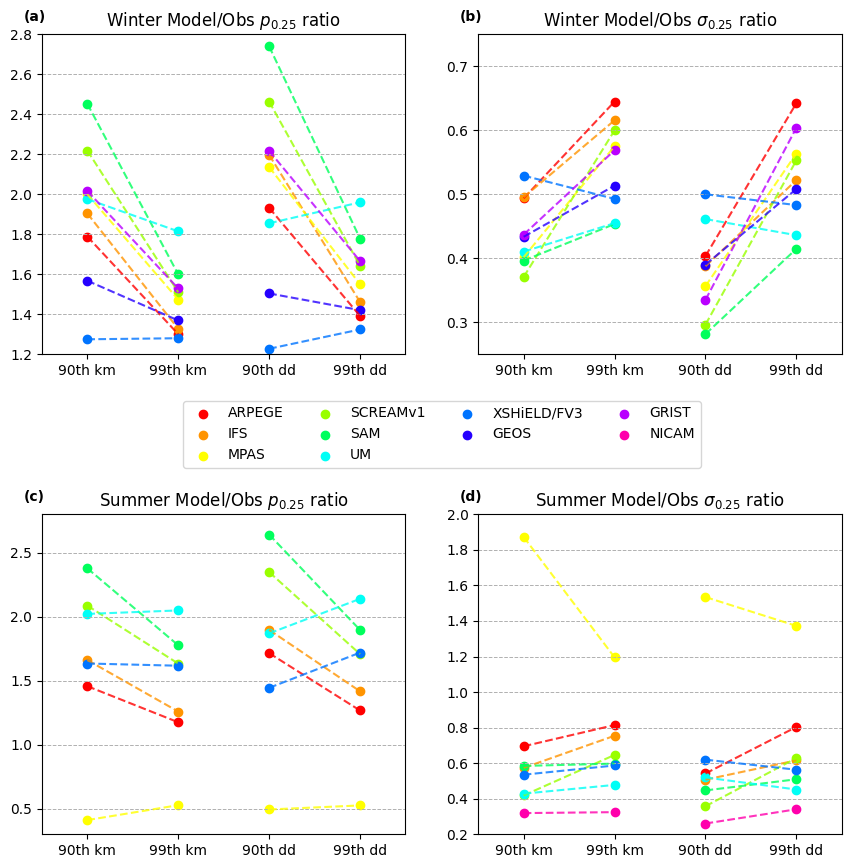

In [35]:
# Plot colors per models
num_colors = 10
cmap = plt.get_cmap('hsv')
color_values = np.linspace(0, 0.9, num_colors)
model_colors = [cmap(value) for value in color_values]
model_colors[2] = (1.0, 1.0, 0.0, 1.0) ## yellow
model_colors[3] = (0.6, 1.0, 0.0, 1.0) ## greenish yellow

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

title1 = "Winter Model/Obs "+r"$p_{0.25}$ ratio"
title2 = "Summer Model/Obs "+r"$p_{0.25}$ ratio"
title3 = "Winter Model/Obs "+r"$\sigma_{0.25}$ ratio"
title4 =  "Summer Model/Obs "+r"$\sigma_{0.25}$ ratio"

# Titles for subplots
axes[0, 0].set_title(title1)
axes[1, 0].set_title(title2)
axes[0, 1].set_title(title3)
axes[1, 1].set_title(title4)

model_handles = {}

# Loop through the index i
for i in np.arange(4):
    # Loop for winter coefficients
    for j, jd_winter in enumerate(jds_winter):
        model_name = jd_winter.name.split("_")[0]
        if model_name == "FV3" or model_name == "XSHiELD":
            # color = model_colors[6]
            model_name = "XSHiELD/FV3"
        
        color = model_colors[j]
        
        if i == 0:
            scat = axes[0, 0].scatter([i], coeffs_wt[j, i], color=color) #, label=model_name
            axes[0, 0].plot([i, i+1], [coeffs_wt[j, i], coeffs_wt[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
            
            axes[0, 1].scatter([i], coeffs_ws[j, i], color=color) #, label=model_name
            axes[0, 1].plot([i, i+1], [coeffs_ws[j, i], coeffs_ws[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

            model_handles[model_name] = scat
        else:
            # Scatter plot for winter coefficients without labels
            axes[0, 0].scatter([i], coeffs_wt[j, i], color=color)
            axes[0, 1].scatter([i], coeffs_ws[j, i], color=color)

            if i ==2 : #? whats that really i==2 means bottom left
                axes[0, 0].plot([i, i+1], [coeffs_wt[j, i], coeffs_wt[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
                axes[0, 1].plot([i, i+1], [coeffs_ws[j, i], coeffs_ws[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

    # Loop for summer coefficients
    for j, jd_summer in enumerate(jds_summer):
        model_name = jd_summer.name.split("_")[0]
        color = model_colors[j]
        if model_name == "NICAM":
            color = model_colors[9]
        elif model_name == "FV3" or model_name == "XSHiELD":
            # color = model_colors[6]
            model_name = "XSHiELD/FV3"

        if i == 0:          
            # Scatter plot for summer coefficients with labels
            scat = axes[1, 0].scatter([i], coeffs_st[j, i], color=color) #, label=model_name_summer
            axes[1, 0].plot([i, i+1], [coeffs_st[j, i], coeffs_st[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

            axes[1, 1].scatter([i], coeffs_ss[j, i], color=color) #, label=model_name_summer
            axes[1, 1].plot([i, i+1], [coeffs_ss[j, i], coeffs_ss[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

            model_handles[model_name] = scat
        else:
            # Scatter plot for summer coefficients without labels
            axes[1, 0].scatter([i], coeffs_st[j, i], color=color)
            axes[1, 1].scatter([i], coeffs_ss[j, i], color=color)
            if i == 2 : #?
                axes[1, 0].plot([i, i+1], [coeffs_st[j, i], coeffs_st[j, i+1]], color = color, linestyle = "--", alpha = 0.8)
                axes[1, 1].plot([i, i+1], [coeffs_ss[j, i], coeffs_ss[j, i+1]], color = color, linestyle = "--", alpha = 0.8)

# Set x-axis labels
x_labels = ['90th km', '99th km', '90th dd', '99th dd']
y_bounds = [(1.2, 2.8), (0.25, 0.75), (0.3, 2.8), (0.2, 2)]
for i, ax, y_bound in zip(np.arange(4), axes.flatten(), y_bounds):
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(x_labels, rotation=0, fontsize=10)
    ax.set_xbound(-0.5, 3.5)
    ax.set_ybound(*y_bound)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

    # # Add legends
    # ax.legend(loc="upper left")
    # ax.legend(loc="upper left")

axes[0,0].text(-0.05, 1.075, "(a)", transform=axes[0,0].transAxes, fontweight='bold', va='top')
axes[1,1].text(-0.05, 1.075, "(b)", transform=axes[0,1].transAxes, fontweight='bold', va='top')
axes[1,0].text(-0.05, 1.075, "(c)", transform=axes[1,0].transAxes, fontweight='bold', va='top')
axes[1,1].text(-0.05, 1.075, "(d)", transform=axes[1,1].transAxes, fontweight='bold', va='top')

fig.legend(
    handles=model_handles.values(),
    labels=model_handles.keys(),
    loc="center",
    ncol=4,  
    bbox_to_anchor=(0.5, 0.5)  # (x, y) in figure coordinates
)

# Adjust layout to prevent overlapping of elements
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.5)
# plt.tight_layout()
plt.savefig("final_fig/fig8.pdf", bbox_inches = "tight")
# plt.show()